***Human Activity Recognition With Raw Data (80-20) split***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [4]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"
#!cp "/content/drive/My Drive/HAR Dataset/HAR Mine/Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv" "accelerometer_extracted_featured_data_without_overlapping.csv"

 acc_data_4sec_before_3sec_after.csv
 acc_data_4sec_before_3sec_after_with_magnitude.csv
 accelerometer_extracted_featured_data_without_overlapping.csv
'Additional Testing Code'
'Basic Data'
 checkpoint
 converted_model.tflite
 frozen_har.pb
 history.p
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
 Human_activity_recognition_feature_extract.ipynb
 human_activity_recognition_MINE_2.ipynb
 human_activity_recognition_MINE.ipynb
 human_activity_recognition_with_raw_data.ipynb
 predictions.p
'Processed Data'
'Subject with number activities performed.gsheet'


# Load Library

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

# Load Data

In [0]:
columns = ['x','y','z', 'timestamp_ms', 'subject_id', 'class', "timestamp_ms"]
df = pd.read_csv('Basic Data/accelerometer_data_merged_all.csv')
#df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [9]:
df.head()

,x,y,z,timestamp_ms,subject_id,class,timestamp_s
0,-0.304352,3.244934,-3.266479,1.560000e+12,1,WALKING_DOWNSTAIRS,1563706375
1,-0.725739,4.875382,-2.603287,1.560000e+12,1,WALKING_DOWNSTAIRS,1563706375
2,-5.396820,4.272049,-0.944107,1.560000e+12,1,WALKING_DOWNSTAIRS,1563706375
3,-4.520538,2.160355,-2.248947,1.560000e+12,1,WALKING_DOWNSTAIRS,1563706375
4,-7.034454,17.066650,2.139618,1.560000e+12,1,WALKING_DOWNSTAIRS,1563706375


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151329 entries, 0 to 151328
Data columns (total 7 columns):
x               151329 non-null float64
y               151329 non-null float64
z               151329 non-null float64
timestamp_ms    151329 non-null float64
subject_id      151329 non-null int64
class           151329 non-null object
timestamp_s     151329 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 9.2+ MB


# Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

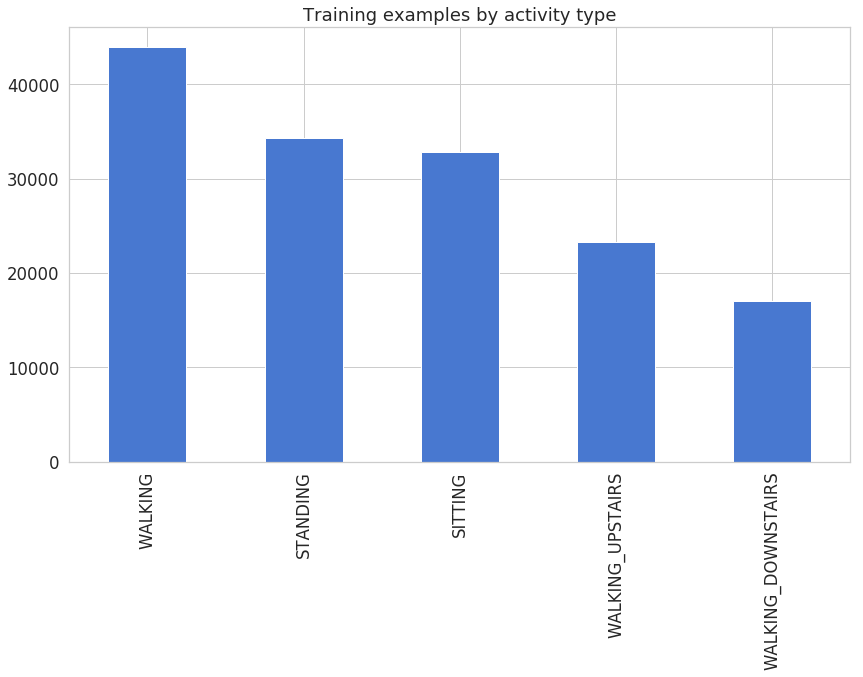

In [12]:
df['class'].value_counts().plot(kind='bar', title='Training examples by activity type');

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

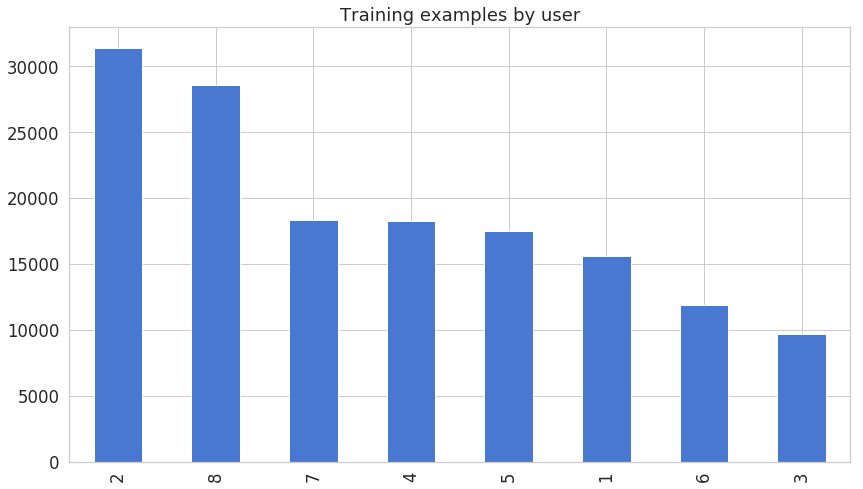

In [13]:
df['subject_id'].value_counts().plot(kind='bar', title='Training examples by user');

I wonder whether or not number 4 received the same paycheck as number 20. Now, for some accelerometer data:

In [0]:
def plot_activity(activity, df):
    data = df[df['class'] == activity][['x', 'y', 'z']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

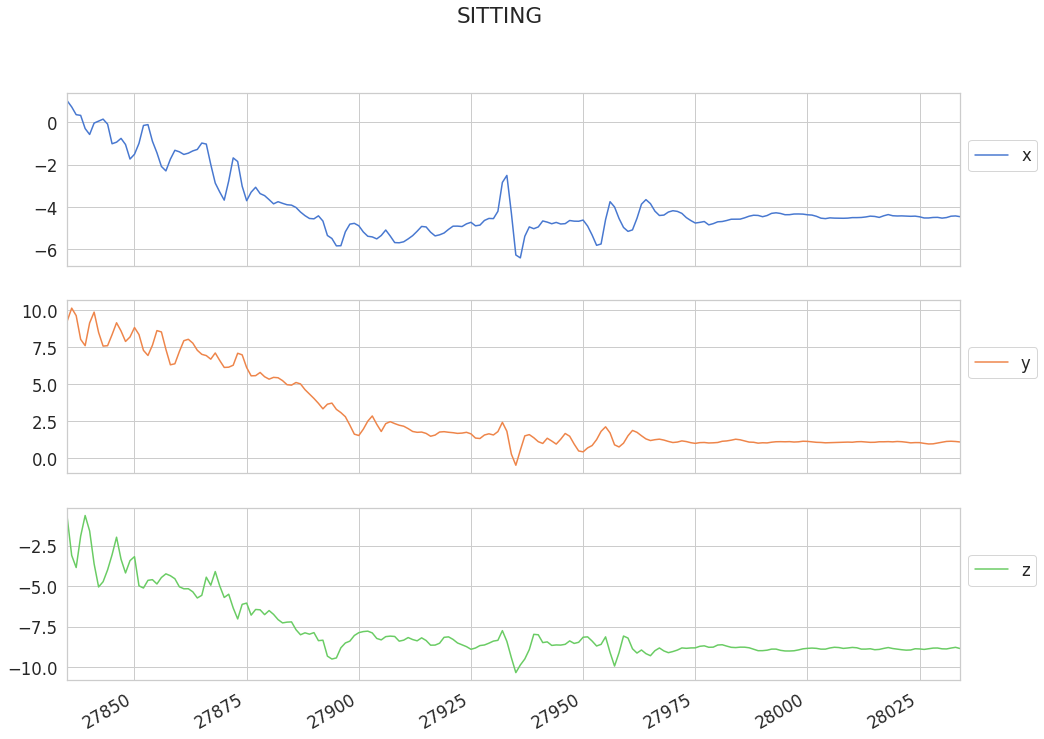

In [19]:
plot_activity("SITTING", df)

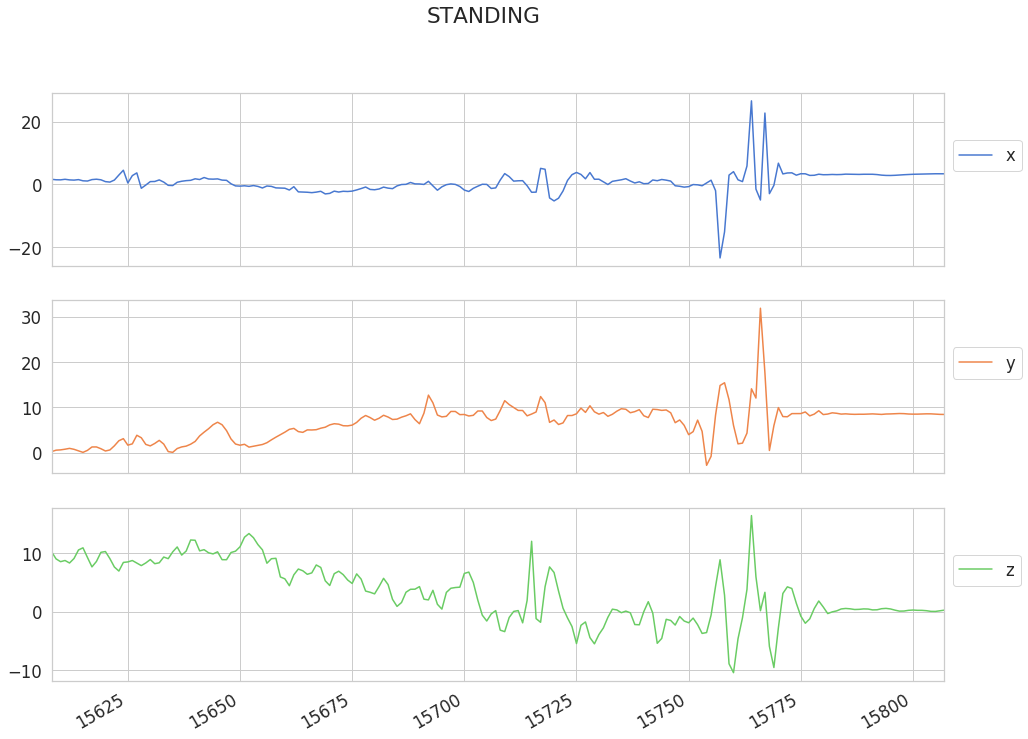

In [20]:
plot_activity("STANDING", df)

In [0]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x'].values[i: i + N_TIME_STEPS]
    ys = df['y'].values[i: i + N_TIME_STEPS]
    zs = df['z'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['class'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [22]:
np.array(segments).shape

(7557, 3, 200)

In [0]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [24]:
reshaped_segments.shape

(7557, 200, 3)

In [25]:
labels[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [27]:
len(X_train)

6045

In [28]:
len(X_test)

1512

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [0]:
N_CLASSES = 5
N_HIDDEN_UNITS = 64

In [0]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

Now, let create placeholders for our model:

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [32]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Finally, let's define optimizer and accuracy ops:

In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [0]:
N_EPOCHS = 50
BATCH_SIZE = 256

In [37]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.8538359999656677 loss: 1.0370876789093018
epoch: 2 test accuracy: 0.9060846567153931 loss: 0.9169325232505798
epoch: 3 test accuracy: 0.9292327761650085 loss: 0.841751217842102
epoch: 4 test accuracy: 0.9457672238349915 loss: 0.7733665704727173
epoch: 5 test accuracy: 0.9338624477386475 loss: 0.773900032043457
epoch: 6 test accuracy: 0.9232804179191589 loss: 0.8107971549034119
epoch: 7 test accuracy: 0.9589946866035461 loss: 0.7001615762710571
epoch: 8 test accuracy: 0.9497354626655579 loss: 0.6830344796180725
epoch: 9 test accuracy: 0.9550264477729797 loss: 0.6621314883232117
epoch: 10 test accuracy: 0.9609788656234741 loss: 0.628342866897583
epoch: 11 test accuracy: 0.9477513432502747 loss: 0.65219646692276
epoch: 12 test accuracy: 0.9656084775924683 loss: 0.5747195482254028
epoch: 13 test accuracy: 0.9609788656234741 loss: 0.569861888885498
epoch: 14 test accuracy: 0.9682539701461792 loss: 0.5426803827285767
epoch: 15 test accuracy: 0.9563491940498352 loss:

Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [0]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'har.pbtxt')  
saver.save(sess, save_path = "har.ckpt")
sess.close()

And loading it back:

In [0]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

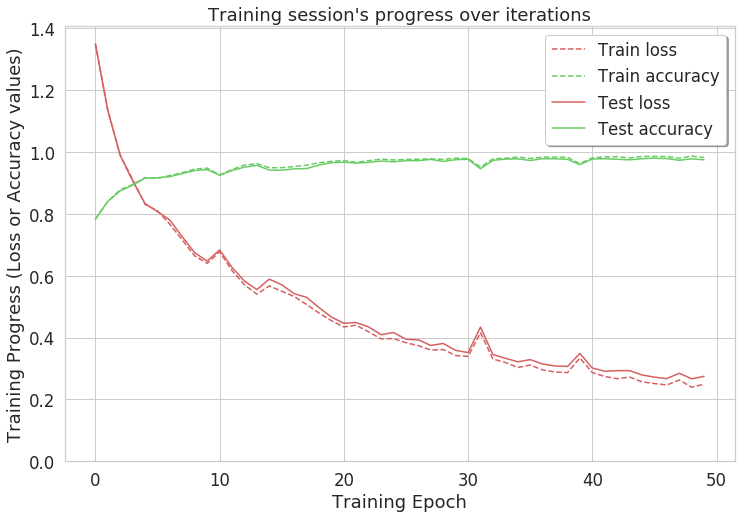

In [0]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [0]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

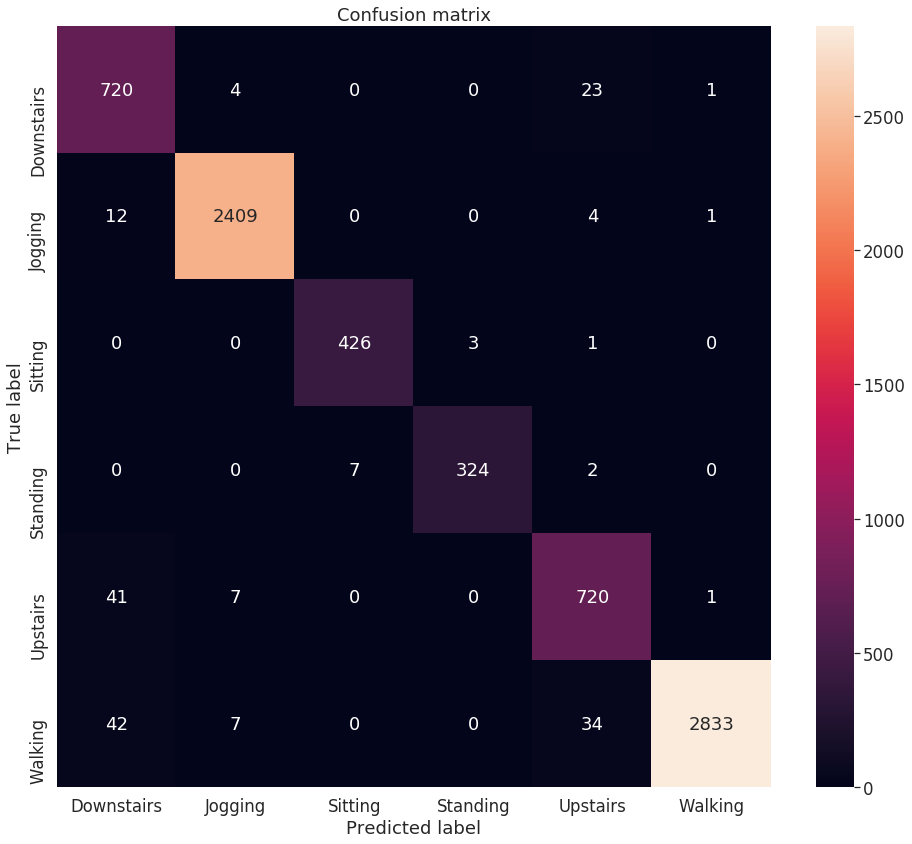

In [0]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

Again, it looks like our model performs real good. Some notable exceptions include the misclassification of  Upstairs for Downstairs and vice versa. Jogging seems to fail us from time to time as well!

# Exporting the model

Now that most of the hard work is done we must export our model in a way that TensorFlow for Android will understand it:

In [0]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

#input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
#checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'

input_graph_path = MODEL_NAME+'.pbtxt'
checkpoint_path = MODEL_NAME+'.ckpt'


restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
#output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

output_frozen_graph_name = 'frozen_model_new'+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Output hidden; open in https://colab.research.google.com to view.

#convert to tflite model

In [0]:
# tensprflow cpu VERSION 1.13.1
# print(tf.__version__)
graph_def_file = "frozen_model_new2.pb"
input_arrays = ["input"]
output_arrays = ["y_"]

converter = tf.lite.TFLiteConverter.from_frozen_graph(
  graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

In [0]:

# Step 4: Check the converted TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_content=tflite_model)

try:
  interpreter.allocate_tensors()
except ValueError:
  assert False

MINI_BATCH_SIZE = 1
correct_case = 0
for i in range(len(X_test)):
  input_index = (interpreter.get_input_details()[0]['index'])
  interpreter.set_tensor(input_index, X_test[i * MINI_BATCH_SIZE: (i + 1) * MINI_BATCH_SIZE])
  interpreter.invoke()
  output_index = (interpreter.get_output_details()[0]['index'])
  result = interpreter.get_tensor(output_index)
  # Reset all variables so it will not pollute other inferences.
  interpreter.reset_all_variables()
  # Evaluate.
  print(result)
  prediction = np.argmax(result)
  #print(prediction, y_test[i],np.argmax(y_test[i]))
  if prediction == np.argmax(y_test[i]):
    correct_case += 1
print (correct_case)
print('TensorFlow Lite Evaluation result is {}'.format(correct_case * 1.0 / len(X_test)))

A sample app that uses the exported model can be found on [GitHub](https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/tree/master/AndroidApp). It is based heavily based on the [Activity Recognition](https://github.com/aqibsaeed/Human-Activity-Recognition-using-CNN/tree/master/ActivityRecognition) app by [Aaqib Saeed](https://aqibsaeed.github.io/). Our app uses the text-to-speech Android API to tell you what the model predicts at some interval and includes our pre-trained model.

The most notable parts of the Java code include defining our input and output dimensions and names:

```java
String INPUT_NODE = "inputs";
String[] OUTPUT_NODES = {"y_"};
String OUTPUT_NODE = "y_";
long[] INPUT_SIZE = {1, 200, 3};
int OUTPUT_SIZE = 6;
```

Creating the TensorFlowInferenceInterface:

```java
inferenceInterface = new TensorFlowInferenceInterface(context.getAssets(), MODEL_FILE);
```

And making the predictions:

```java
public float[] predictProbabilities(float[] data) {
    float[] result = new float[OUTPUT_SIZE];
    inferenceInterface.feed(INPUT_NODE, data, INPUT_SIZE);
    inferenceInterface.run(OUTPUT_NODES);
    inferenceInterface.fetch(OUTPUT_NODE, result);

    //Downstairs	Jogging	  Sitting	Standing	Upstairs	Walking
    return result;
}
```

The result is a float array that contains the probability for each possible activity, according to our model.

# Conclusion

We've built an LSTM model that can predict human activity from 200 time-step sequence with over 97% accuracy on the test set. The model was exported and used in an Android app. I had a lot of fun testing it on my phone, but it seems like more fine tuning (or changing the dataset) is required. Did you try the app? Can you improve it?

# References

- [CNN for Human Activity Recognition](https://github.com/aqibsaeed/Human-Activity-Recognition-using-CNN)
- [LSTMs for Human Activity Recognition](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)
- [Activity Recognition using Cell Phone Accelerometers](http://www.cis.fordham.edu/wisdm/public_files/sensorKDD-2010.pdf)
- [WIreless Sensor Data Mining Lab](http://www.cis.fordham.edu/wisdm/dataset.php)